Khai báo các thư viện cần dùng


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import scipy.stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes  import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, explained_variance_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')


# Mô hình phân loại

### Xử lý dữ liệu

In [4]:
df = pd.read_csv("music_genre.csv")
df.columns = df.columns.str.strip()

df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [5]:
df.shape

(50005, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [7]:
# Đưa dữ liệu về dạng numpy
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')
df = df.drop_duplicates().dropna()
# tách thêm instance_id, track_name: ID và tên bài hát
X_origin = df.drop(['music_genre', 'instance_id', 'track_name'], axis=1)
y_origin = df['music_genre']
print(X_origin.shape)
print(y_origin.shape)

(45020, 15)
(45020,)


In [8]:
lable_columns = ['artist_name', 'key', 'mode', 'obtained_date']

# Label Encoding cho từng cột
X_encoded_lable_df = X_origin[lable_columns].apply(lambda col: LabelEncoder().fit_transform(col))

# Tạo mảng numpy và danh sách cột mã hóa
X_encoded = X_encoded_lable_df.values
encoded_columns_final = [f"{col}_encoded" for col in lable_columns]

# Tạo DataFrame mã hóa
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns_final, index=X_origin.index)

# Gộp với phần dữ liệu còn lại
columns_to_drop = lable_columns
X_encode = pd.concat([X_origin.drop(columns=columns_to_drop), X_encoded_df], axis=1)

# In kết quả
print("DataFrame gốc:")
print(X_origin)
print("\n" + "="*30 + "\n")
print("DataFrame đã mã hóa hoàn chỉnh:")
print(X_encode)

DataFrame gốc:
                artist_name  popularity  acousticness  danceability  \
0                  Röyksopp        27.0       0.00468         0.652   
1      Thievery Corporation        31.0       0.01270         0.622   
2            Dillon Francis        28.0       0.00306         0.620   
3                  Dubloadz        34.0       0.02540         0.774   
4               What So Not        32.0       0.00465         0.638   
...                     ...         ...           ...           ...   
50000                 BEXEY        59.0       0.03340         0.913   
50001             Roy Woods        72.0       0.15700         0.709   
50002                Berner        51.0       0.00597         0.693   
50003             The-Dream        65.0       0.08310         0.782   
50004     Naughty By Nature        67.0       0.10200         0.862   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0             -1.0   0.941           0.79200  A#     

In [9]:
#Dữ liệu liên tục
continous_data = [
    'popularity', 'acousticness', 'danceability', 'duration_ms',
    'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
#Dữ liệu rời rạc
classified_data = ['artist_name_encoded', 'key_encoded', 'mode_encoded', 'obtained_date_encoded']

X_encoded_df = pd.DataFrame(X_encode)

X_continous = X_encoded_df[continous_data]     #Dữ liệu liên tục
X_classified = X_encoded_df[classified_data]   #Dữ liệu rời rạc

In [10]:
X_continous


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323
...,...,...,...,...,...,...,...,...,...,...,...
50000,59.0,0.03340,0.913,-1.0,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330
50001,72.0,0.15700,0.709,251860.0,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113
50002,51.0,0.00597,0.693,189483.0,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395
50003,65.0,0.08310,0.782,262773.0,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354


In [11]:
X_classified

,artist_name_encoded,key_encoded,mode_encoded,obtained_date_encoded
0,4833,1,1,2
1,5880,5,1,2
2,1527,11,0,2
3,1638,4,0,2
4,6268,9,0,2
...,...,...,...,...
50000,475,4,0,2
50001,4785,2,0,2
50002,588,5,0,2
50003,5868,10,1,2


In [12]:
# Chuẩn hoá dữ liệu liên tục
scaler = StandardScaler()
X_continous_scaled = scaler.fit_transform(X_continous)

In [13]:
X_continous_scaled

array([[-1.10991062, -0.8843778 ,  0.52258528, ..., -0.1870859 ,
        -0.6221643 ,  1.22434325],
       [-0.85273873, -0.86088544,  0.35485278, ..., -0.62860616,
        -0.1615777 ,  0.30185558],
       [-1.04561764, -0.88912314,  0.34367061, ..., -0.58425703,
         0.26242436, -0.49925212],
       ...,
       [ 0.4331207 , -0.88059911,  0.75181969, ...,  0.51461595,
         0.36310527, -0.24840021],
       [ 1.3332223 , -0.65466816,  1.2494261 , ..., -0.48964554,
        -1.43815287, -0.41428615],
       [ 1.46180824, -0.59930586,  1.69671277, ...,  0.07112461,
        -0.67725324,  1.24861924]])

In [14]:
# Ghép dữ liệu liên tục đã chuẩn hoá với dữ liệu rời rạc
X_encoded_std = np.concatenate([X_classified.values, X_continous_scaled], axis=1)
new_columns = classified_data + continous_data
X_encoded_std_df = pd.DataFrame(X_encoded_std, columns=new_columns)

In [15]:
X_encoded_std

array([[ 4.83300000e+03,  1.00000000e+00,  1.00000000e+00, ...,
        -1.87085897e-01, -6.22164300e-01,  1.22434325e+00],
       [ 5.88000000e+03,  5.00000000e+00,  1.00000000e+00, ...,
        -6.28606160e-01, -1.61577701e-01,  3.01855584e-01],
       [ 1.52700000e+03,  1.10000000e+01,  0.00000000e+00, ...,
        -5.84257026e-01,  2.62424360e-01, -4.99252122e-01],
       ...,
       [ 5.88000000e+02,  5.00000000e+00,  0.00000000e+00, ...,
         5.14615949e-01,  3.63105268e-01, -2.48400214e-01],
       [ 5.86800000e+03,  1.00000000e+01,  1.00000000e+00, ...,
        -4.89645542e-01, -1.43815287e+00, -4.14286154e-01],
       [ 4.03200000e+03,  9.00000000e+00,  1.00000000e+00, ...,
         7.11246137e-02, -6.77253238e-01,  1.24861924e+00]])

In [16]:
X_encoded_std_df

,artist_name_encoded,key_encoded,mode_encoded,obtained_date_encoded,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,4833.0,1.0,1.0,2.0,-1.109911,-0.884378,0.522585,-1.732130,1.290882,1.872550,-0.488216,0.639344,-0.187086,-0.622164,1.224343
1,5880.0,5.0,1.0,2.0,-0.852739,-0.860885,0.354853,-0.022528,1.098070,2.357446,-0.432561,0.340140,-0.628606,-0.161578,0.301856
2,1527.0,11.0,0.0,2.0,-1.045618,-0.889123,0.343671,-0.043517,0.587686,-0.521854,2.102795,0.734206,-0.584257,0.262424,-0.499252
3,1638.0,4.0,0.0,2.0,-0.659860,-0.823684,1.204697,-0.425216,0.379752,-0.550303,-0.228496,0.753536,1.431165,0.263077,-0.754150
4,6268.0,9.0,0.0,2.0,-0.788446,-0.884466,0.444310,0.009394,-0.047459,2.231618,-0.228496,0.466352,-0.517241,0.818601,-0.539712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45015,475.0,4.0,0.0,2.0,0.947464,-0.800251,1.981858,-1.732130,-0.096607,-0.558068,-0.463480,0.343551,2.012631,-0.715535,-0.511390
45016,4785.0,2.0,0.0,2.0,1.783273,-0.438199,0.841277,0.240357,-0.898099,-0.558068,-0.525318,-0.109966,-0.382222,0.068210,-1.389372
45017,588.0,5.0,0.0,2.0,0.433121,-0.880599,0.751820,-0.248158,0.617931,-0.558068,-0.315069,0.600035,0.514616,0.363105,-0.248400
45018,5868.0,10.0,1.0,2.0,1.333222,-0.654668,1.249426,0.325824,-0.482231,-0.558068,-0.543870,0.669395,-0.489646,-1.438153,-0.414286


### Navie Bayes

#### Tự định nghĩa lớp MyNaviesBayes

In [17]:
class MyNavieBayes:
  def __init__(self):
    self.mu_list_gs = None
    self.mu_list_cg = None
    self.std_list = None
    self.pi_list = None
    self.classes_ = None

  def fit(self, X, y):
    if len(X) == 2:
      self.X_continous = X[0]
      self.X_classified = X[1]
      self.y = y
      self.classes_ = np.unique(y)

      self.fit_Gaussian(self.X_continous, self.y)
      self.fit_Categorical(self.X_classified, self.y)
    else:
      self.X = X
      self.y = y
      self.classes_ = np.unique(y)
      self.fit_Gaussian(self.X, self.y)

  def fit_Gaussian(self, X, y):

    self.mu_list_gs = []
    self.std_list = []
    self.pi_list = []

    for c in self.classes_:
        X_c = X[y == c]  # chọn mẫu có nhãn c
        self.mu_list_gs.append(np.mean(X_c, axis=0))
        self.std_list.append(np.std(X_c, axis=0) + 1e-9)  # tránh chia cho 0
        self.pi_list.append(len(X_c) / len(X))

    self.mu_list_gs = np.array(self.mu_list_gs)
    self.std_list = np.array(self.std_list)
    self.pi_list = np.array(self.pi_list)

  def fit_Categorical(self, X, y):
    n_features = X.shape[1]

    self.mu_list_cg = []

    for c in self.classes_:
        X_c = X[y == c]

        probs_per_feature = []
        for j in range(n_features):
            values, counts = np.unique(X_c[:, j], return_counts=True)
            max_val = int(np.max(X[:, j])) + 1
            probs = np.zeros(max_val)
            probs[values.astype(int)] = counts
            probs_per_feature.append(probs)
        self.mu_list_cg.append(probs_per_feature)

  def predict_GaussianNB(self, X):
    y_pred = []
    for x in X:  # duyệt từng mẫu test
        scores_list = []
        for p in range(len(self.classes_)):
            # Tính tích của PDF cho tất cả các feature
            probs = norm.pdf(x=x, loc=self.mu_list_gs[p], scale=self.std_list[p])
            score = np.prod(probs) * self.pi_list[p]
            scores_list.append(score)
        y_pred.append(scores_list)
    return np.array(y_pred)

  def predict_CategoricalNB(self, X):
    log_scores = []
    for c in range(len(self.classes_)):
        probs_per_feature = self.mu_list_cg[c]
        log_score = np.log(self.pi_list[c] + 1e-12)  # tránh log(0)
        for j, xi in enumerate(X):
            probs = probs_per_feature[j] / np.sum(probs_per_feature[j])
            if int(xi) < len(probs):
                log_score += np.log(probs[int(xi)] + 1e-12)
            else:
                log_score += np.log(1e-6)  # smoothing
        log_scores.append(log_score)
    # Chuyển log-probabilities về xác suất tương đối
    log_scores = np.array(log_scores)
    scores = np.exp(log_scores - np.max(log_scores))  # để tránh overflow
    return scores / np.sum(scores)


  def predict_all_CategoricalNB(self, X):
    preds = []
    for i in range(X.shape[0]):       # Lặp qua từng hàng (mẫu)
        preds.append(self.predict_CategoricalNB(X[i]))
    return np.array(preds)

  def predict(self, X):
    log_pred_gaussian = np.log(self.predict_GaussianNB(X) + 1e-12)
    return np.array([self.classes_[np.argmax(row)] for row in log_pred_gaussian])

  def predict_all(self, X):
    log_pred_gaussian = np.log(self.predict_GaussianNB(X[0]) + 1e-12)
    log_pred_categorical = np.log(self.predict_all_CategoricalNB(X[1]) + 1e-12)
    log_pred_gaussian /= X[0].shape[1]
    log_pred_categorical /= X[1].shape[1]
    log_pred_all = log_pred_gaussian + log_pred_categorical
    return np.array([self.classes_[np.argmax(row)] for row in log_pred_all])


#### HybridNavieBayes

In [18]:
class HybridNaiveBayes:
    def __init__(self):
        self.model_gaussian = GaussianNB()
        self.model_categorical = CategoricalNB()
        self.classes_ = None

    def fit(self, X, y):
        self.model_gaussian.fit(X[0], y)
        self.model_categorical.fit(X[1], y)
        self.classes_ = self.model_gaussian.classes_

    def predict_log_proba(self, X):
        X_gaussian, X_categorical = X[0], X[1]
        log_prob_gauss = self.model_gaussian.predict_log_proba(X_gaussian)
        log_prob_categ = self.model_categorical.predict_log_proba(X_categorical)
        log_prob_gauss /= X[0].shape[1]
        log_prob_categ /= X[1].shape[1]
        log_prob_total = log_prob_gauss + log_prob_categ
        return log_prob_total

    def predict_proba(self, X):
        log_prob_total = self.predict_log_proba(X)
        prob_total = np.exp(log_prob_total)
        prob_total /= prob_total.sum(axis=1, keepdims=True)
        return prob_total

    def predict_all(self, X):
        prob_total = self.predict_proba(X)
        return self.classes_[np.argmax(prob_total, axis=1)]


#### Các hàm hỗ trợ

In [19]:
def split_train_test(X, y, test_size=None, classified_idx=None):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  if classified_idx == 0:
    return (X_train, X_test, y_train, y_test)

  X_train_classicfied = X_train[:,:classified_idx]
  X_test_classicfied = X_test[:,:classified_idx]
  X_train_continous = X_train[:,classified_idx:]
  X_test_continous = X_test[:,classified_idx:]
  X_train_all = [X_train_continous, X_train_classicfied]
  X_test_all = [X_test_continous, X_test_classicfied]
  return (X_train_all, X_test_all, y_train, y_test)


In [20]:
def auto_predict(X_train, X_test, y_train, y_test, model = None, string = "String Default"):
  if len(X_train)==2:
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict_all(X_test)
    end_time = time.time()
  else:
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

  print()
  print('=' * 20, string, '=' * 20)
  print(f'Total time: {end_time - start_time:.4f} seconds')

  print(f'Accuracy of model {model.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}')
  print("\n Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

  print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
  print('=' * 100)
  print()

In [21]:
def auto_predict_with_reduction(X, y, model = None, reduce_name = None, n_components=None, test_size=None):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  if reduce_name == 'PCA':
    model_rd = PCA(n_components=n_components)
    X_train = model_rd.fit_transform(X_train)
    X_test = model_rd.transform(X_test)
  elif reduce_name == 'LDA':
    model_rd = LDA(n_components=n_components)
    X_train = model_rd.fit_transform(X_train, y_train)
    X_test = model_rd.transform(X_test)

  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  end_time = time.time()

  print()
  print('=' * 20, f"Chạy với dữ liệu đã giảm chiều bằng {reduce_name} với train:validation = {int(10-test_size*10)}:{int(test_size*10)}", '=' * 20)
  print(f"Số chiều sau khi giảm: {n_components}")
  print(f'Total time: {end_time - start_time:.4f} seconds')

  print(f'Accuracy of model {model.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}')
  print("\n Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

  print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
  print('=' * 100)
  print()

# Dự đoán với mô hình

### Dữ liệu ban đầu đã encode và chuẩn hoá

#### Thực nghiệm với mô hình tự định nghĩa

In [22]:
X, y = X_encoded_std.copy(), y_origin.copy()
classified_idx = 4

In [23]:
model = MyNavieBayes()
auto_predict(*split_train_test(X, y, test_size=0.2, classified_idx=classified_idx), model=model, string="Chạy với dữ liệu ban đầu có train:validation = 4:1")


==================== Chạy với dữ liệu ban đầu có train:validation = 4:1 ====================
Total time: 11.1514 seconds
Accuracy of model MyNavieBayes: 0.7669

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.68      0.62      0.65       856
       Anime       0.97      0.92      0.94       919
       Blues       0.87      0.84      0.85       873
   Classical       0.91      0.95      0.93       881
     Country       0.72      0.93      0.81       921
  Electronic       0.87      0.92      0.89       931
     Hip-Hop       0.53      0.59      0.56       905
        Jazz       0.86      0.81      0.83       888
         Rap       0.52      0.50      0.51       914
        Rock       0.76      0.58      0.66       916

    accuracy                           0.77      9004
   macro avg       0.77      0.77      0.77      9004
weighted avg       0.77      0.77      0.77      9004

Confusion matrix:
[[535   1  10   1  63  31  65  15  3

In [24]:
model = MyNavieBayes()
auto_predict(*split_train_test(X, y, test_size=0.3, classified_idx=classified_idx), model=model, string="Chạy với dữ liệu ban đầu có train:validation = 7:3")


==================== Chạy với dữ liệu ban đầu có train:validation = 7:3 ====================
Total time: 16.3951 seconds
Accuracy of model MyNavieBayes: 0.7667

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.69      0.63      0.66      1321
       Anime       0.97      0.92      0.94      1382
       Blues       0.87      0.83      0.85      1312
   Classical       0.91      0.95      0.93      1339
     Country       0.71      0.93      0.80      1354
  Electronic       0.88      0.92      0.90      1405
     Hip-Hop       0.53      0.60      0.56      1345
        Jazz       0.86      0.80      0.83      1325
         Rap       0.52      0.49      0.51      1337
        Rock       0.76      0.58      0.66      1386

    accuracy                           0.77     13506
   macro avg       0.77      0.77      0.76     13506
weighted avg       0.77      0.77      0.77     13506

Confusion matrix:
[[ 832    1   15    5  109   35   97

In [25]:
model = MyNavieBayes()
auto_predict(*split_train_test(X, y, test_size=0.4, classified_idx=classified_idx), model, string="Chạy với dữ liệu ban đầu có train:validation = 6:4")


==================== Chạy với dữ liệu ban đầu có train:validation = 6:4 ====================
Total time: 22.2195 seconds
Accuracy of model MyNavieBayes: 0.7628

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.70      0.63      0.66      1764
       Anime       0.96      0.92      0.94      1840
       Blues       0.88      0.81      0.84      1799
   Classical       0.90      0.95      0.93      1789
     Country       0.68      0.92      0.78      1779
  Electronic       0.88      0.91      0.89      1829
     Hip-Hop       0.53      0.61      0.57      1784
        Jazz       0.85      0.80      0.82      1777
         Rap       0.53      0.49      0.51      1798
        Rock       0.76      0.57      0.65      1849

    accuracy                           0.76     18008
   macro avg       0.77      0.76      0.76     18008
weighted avg       0.77      0.76      0.76     18008

Confusion matrix:
[[1106    1   19    6  151   43  131

#### Thực nghiệm với thư viện Sklearn

In [26]:
model_hybrid = HybridNaiveBayes()
auto_predict(*split_train_test(X, y, test_size=0.2, classified_idx=classified_idx), model=model_hybrid, string="Chạy với dữ liệu ban đầu có train:validation = 4:1 (sklearn)")


==================== Chạy với dữ liệu ban đầu có train:validation = 4:1 (sklearn) ====================
Total time: 0.1962 seconds
Accuracy of model HybridNaiveBayes: 0.7122

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.66      0.55      0.60       856
       Anime       0.95      0.85      0.90       919
       Blues       0.85      0.77      0.81       873
   Classical       0.82      0.89      0.85       881
     Country       0.63      0.90      0.74       921
  Electronic       0.81      0.85      0.83       931
     Hip-Hop       0.50      0.57      0.53       905
        Jazz       0.76      0.68      0.72       888
         Rap       0.50      0.48      0.49       914
        Rock       0.73      0.55      0.63       916

    accuracy                           0.71      9004
   macro avg       0.72      0.71      0.71      9004
weighted avg       0.72      0.71      0.71      9004

Confusion matrix:
[[471   1  10   5  90  

In [27]:
model_hybrid = HybridNaiveBayes()
auto_predict(*split_train_test(X, y, test_size=0.3, classified_idx=classified_idx), model=model_hybrid, string="Chạy với dữ liệu ban đầu có train:validation = 7:3 (sklearn)")


==================== Chạy với dữ liệu ban đầu có train:validation = 7:3 (sklearn) ====================
Total time: 0.2025 seconds
Accuracy of model HybridNaiveBayes: 0.7090

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.67      0.56      0.61      1321
       Anime       0.95      0.83      0.88      1382
       Blues       0.84      0.76      0.80      1312
   Classical       0.80      0.90      0.84      1339
     Country       0.61      0.91      0.73      1354
  Electronic       0.82      0.85      0.84      1405
     Hip-Hop       0.50      0.58      0.54      1345
        Jazz       0.75      0.66      0.70      1325
         Rap       0.50      0.48      0.49      1337
        Rock       0.74      0.56      0.64      1386

    accuracy                           0.71     13506
   macro avg       0.72      0.71      0.71     13506
weighted avg       0.72      0.71      0.71     13506

Confusion matrix:
[[ 735    1   15   13  

In [28]:
model_hybrid = HybridNaiveBayes()
auto_predict(*split_train_test(X, y, test_size=0.4, classified_idx=classified_idx), model=model_hybrid, string="Chạy với dữ liệu ban đầu có train:validation = 6:4 (sklearn)")


==================== Chạy với dữ liệu ban đầu có train:validation = 6:4 (sklearn) ====================
Total time: 0.1810 seconds
Accuracy of model HybridNaiveBayes: 0.7014

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.67      0.54      0.60      1764
       Anime       0.94      0.83      0.88      1840
       Blues       0.85      0.74      0.79      1799
   Classical       0.80      0.90      0.85      1789
     Country       0.57      0.91      0.70      1779
  Electronic       0.81      0.84      0.82      1829
     Hip-Hop       0.50      0.60      0.55      1784
        Jazz       0.75      0.64      0.69      1777
         Rap       0.51      0.47      0.49      1798
        Rock       0.73      0.55      0.62      1849

    accuracy                           0.70     18008
   macro avg       0.71      0.70      0.70     18008
weighted avg       0.72      0.70      0.70     18008

Confusion matrix:
[[ 946    1   19   16  

#### Nhận xét

Kết quả so sánh

Mô hình tự cài đặt (GaussianNB + CategoricalNB): độ chính xác ≈ 76%

Mô hình sklearn (GaussianNB + CategoricalNB): độ chính xác ≈ 70%

→ Mô hình sử dụng numpy thuần hoạt động hiệu quả hơn trên cùng dữ liệu và cùng tỷ lệ train/test (4:1, 7:3, 6:4).

Nguyên nhân chính

(1) Smoothing khác nhau: Phương pháp thủ công đã thêm 1e-6 khi xác suất bằng 0 → tránh overfitting vào lớp có tần suất cao, mô hình ổn định hơn.

(2) Dữ liệu không thật: Gaussian	Sklearn GaussianNB hoạt động kém nếu dữ liệu không phân phối chuẩn, trong khi cách numpy thuần nhân hàm mật độ xác suất (PDF) rồi chuẩn hóa lại có thể “mềm hóa” lỗi giả định này.

### Dữ liệu đã giảm chiều

#### Giảm chiều trên cả tập dữ liệu

In [29]:
X, y = X_encoded_std.copy(), y_origin.copy()

In [30]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 6
Total time: 6.3966 seconds
Accuracy of model MyNavieBayes: 0.3598

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.22      0.14      0.17       856
       Anime       0.47      0.40      0.43       919
       Blues       0.32      0.16      0.21       873
   Classical       0.70      0.84      0.76       881
     Country       0.24      0.41      0.31       921
  Electronic       0.28      0.14      0.18       931
     Hip-Hop       0.43      0.51      0.46       905
        Jazz       0.31      0.33      0.32       888
         Rap       0.42      0.26      0.32       914
        Rock       0.24      0.42      0.30       916

    accuracy                           0.36      9004
   macro avg       0.36      0.36      0.35      9004
weighted avg       0.36      0.36      0.35      9004

Confusion matr

In [31]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 6
Total time: 22.3519 seconds
Accuracy of model MyNavieBayes: 0.3547

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.23      0.13      0.17      1321
       Anime       0.47      0.39      0.43      1382
       Blues       0.30      0.16      0.21      1312
   Classical       0.70      0.84      0.76      1339
     Country       0.23      0.42      0.30      1354
  Electronic       0.26      0.13      0.17      1405
     Hip-Hop       0.41      0.45      0.43      1345
        Jazz       0.31      0.32      0.32      1325
         Rap       0.39      0.28      0.33      1337
        Rock       0.25      0.42      0.31      1386

    accuracy                           0.35     13506
   macro avg       0.36      0.35      0.34     13506
weighted avg       0.36      0.35      0.34     13506

Confusion mat

In [32]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 6
Total time: 15.5204 seconds
Accuracy of model MyNavieBayes: 0.3573

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.14      0.18      1764
       Anime       0.48      0.38      0.43      1840
       Blues       0.32      0.17      0.22      1799
   Classical       0.69      0.84      0.76      1789
     Country       0.23      0.44      0.30      1779
  Electronic       0.23      0.12      0.16      1829
     Hip-Hop       0.41      0.46      0.43      1784
        Jazz       0.33      0.34      0.33      1777
         Rap       0.41      0.28      0.33      1798
        Rock       0.25      0.41      0.31      1849

    accuracy                           0.36     18008
   macro avg       0.36      0.36      0.35     18008
weighted avg       0.36      0.36      0.35     18008

Confusion mat

In [33]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 6
Total time: 0.1075 seconds
Accuracy of model GaussianNB: 0.3600

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.22      0.14      0.17       856
       Anime       0.47      0.40      0.43       919
       Blues       0.32      0.16      0.21       873
   Classical       0.70      0.84      0.76       881
     Country       0.24      0.41      0.31       921
  Electronic       0.28      0.14      0.18       931
     Hip-Hop       0.43      0.51      0.46       905
        Jazz       0.31      0.33      0.32       888
         Rap       0.42      0.26      0.32       914
        Rock       0.24      0.42      0.30       916

    accuracy                           0.36      9004
   macro avg       0.36      0.36      0.35      9004
weighted avg       0.36      0.36      0.35      9004

Confusion matrix

In [34]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 6
Total time: 0.1013 seconds
Accuracy of model GaussianNB: 0.3550

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.23      0.13      0.17      1321
       Anime       0.47      0.39      0.43      1382
       Blues       0.30      0.16      0.21      1312
   Classical       0.70      0.84      0.76      1339
     Country       0.23      0.42      0.30      1354
  Electronic       0.26      0.13      0.17      1405
     Hip-Hop       0.41      0.45      0.43      1345
        Jazz       0.31      0.33      0.32      1325
         Rap       0.39      0.28      0.33      1337
        Rock       0.25      0.42      0.31      1386

    accuracy                           0.36     13506
   macro avg       0.36      0.35      0.34     13506
weighted avg       0.36      0.36      0.34     13506

Confusion matrix

In [35]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 6
Total time: 0.0921 seconds
Accuracy of model GaussianNB: 0.3577

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.14      0.18      1764
       Anime       0.48      0.38      0.43      1840
       Blues       0.32      0.16      0.22      1799
   Classical       0.69      0.84      0.76      1789
     Country       0.23      0.44      0.30      1779
  Electronic       0.24      0.12      0.16      1829
     Hip-Hop       0.41      0.46      0.43      1784
        Jazz       0.33      0.34      0.33      1777
         Rap       0.41      0.28      0.33      1798
        Rock       0.25      0.42      0.31      1849

    accuracy                           0.36     18008
   macro avg       0.36      0.36      0.35     18008
weighted avg       0.36      0.36      0.35     18008

Confusion matrix

In [36]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 2
Total time: 7.6190 seconds
Accuracy of model MyNavieBayes: 0.4037

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.35      0.29       856
       Anime       0.64      0.57      0.60       919
       Blues       0.36      0.46      0.41       873
   Classical       0.76      0.85      0.80       881
     Country       0.27      0.20      0.23       921
  Electronic       0.30      0.26      0.28       931
     Hip-Hop       0.33      0.29      0.31       905
        Jazz       0.38      0.23      0.29       888
         Rap       0.45      0.40      0.42       914
        Rock       0.32      0.43      0.37       916

    accuracy                           0.40      9004
   macro avg       0.41      0.40      0.40      9004
weighted avg       0.41      0.40      0.40      9004

Confusion matr

In [37]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 2
Total time: 10.4098 seconds
Accuracy of model MyNavieBayes: 0.4024

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.32      0.28      1321
       Anime       0.65      0.56      0.61      1382
       Blues       0.35      0.45      0.40      1312
   Classical       0.75      0.85      0.80      1339
     Country       0.26      0.21      0.23      1354
  Electronic       0.31      0.26      0.28      1405
     Hip-Hop       0.35      0.25      0.29      1345
        Jazz       0.36      0.22      0.28      1325
         Rap       0.43      0.47      0.45      1337
        Rock       0.33      0.42      0.37      1386

    accuracy                           0.40     13506
   macro avg       0.40      0.40      0.40     13506
weighted avg       0.40      0.40      0.40     13506

Confusion mat

In [38]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 2
Total time: 13.3317 seconds
Accuracy of model MyNavieBayes: 0.4046

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.32      0.28      1764
       Anime       0.66      0.56      0.61      1840
       Blues       0.37      0.46      0.41      1799
   Classical       0.75      0.84      0.80      1789
     Country       0.25      0.21      0.23      1779
  Electronic       0.31      0.27      0.29      1829
     Hip-Hop       0.35      0.20      0.25      1784
        Jazz       0.38      0.24      0.29      1777
         Rap       0.41      0.50      0.45      1798
        Rock       0.32      0.43      0.37      1849

    accuracy                           0.40     18008
   macro avg       0.41      0.40      0.40     18008
weighted avg       0.41      0.40      0.40     18008

Confusion mat

In [39]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 2
Total time: 0.1385 seconds
Accuracy of model GaussianNB: 0.4037

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.35      0.29       856
       Anime       0.64      0.57      0.60       919
       Blues       0.36      0.46      0.41       873
   Classical       0.76      0.85      0.80       881
     Country       0.27      0.20      0.23       921
  Electronic       0.30      0.26      0.28       931
     Hip-Hop       0.33      0.29      0.31       905
        Jazz       0.38      0.23      0.29       888
         Rap       0.45      0.40      0.42       914
        Rock       0.32      0.43      0.37       916

    accuracy                           0.40      9004
   macro avg       0.41      0.40      0.40      9004
weighted avg       0.41      0.40      0.40      9004

Confusion matrix

In [40]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 2
Total time: 0.0999 seconds
Accuracy of model GaussianNB: 0.4024

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.32      0.28      1321
       Anime       0.65      0.56      0.61      1382
       Blues       0.35      0.45      0.40      1312
   Classical       0.75      0.85      0.80      1339
     Country       0.26      0.21      0.23      1354
  Electronic       0.31      0.26      0.28      1405
     Hip-Hop       0.35      0.25      0.29      1345
        Jazz       0.36      0.22      0.28      1325
         Rap       0.43      0.47      0.45      1337
        Rock       0.33      0.42      0.37      1386

    accuracy                           0.40     13506
   macro avg       0.40      0.40      0.40     13506
weighted avg       0.40      0.40      0.40     13506

Confusion matrix

In [41]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 2
Total time: 0.1456 seconds
Accuracy of model GaussianNB: 0.4046

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.32      0.28      1764
       Anime       0.66      0.56      0.61      1840
       Blues       0.37      0.46      0.41      1799
   Classical       0.75      0.84      0.80      1789
     Country       0.25      0.21      0.23      1779
  Electronic       0.31      0.27      0.29      1829
     Hip-Hop       0.35      0.20      0.25      1784
        Jazz       0.38      0.24      0.29      1777
         Rap       0.41      0.50      0.45      1798
        Rock       0.32      0.43      0.37      1849

    accuracy                           0.40     18008
   macro avg       0.41      0.40      0.40     18008
weighted avg       0.41      0.40      0.40     18008

Confusion matrix

#### Giảm chiều trên tập liên tục

In [42]:
X, y = X_continous_scaled.copy(), y_origin.copy()

In [43]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 6
Total time: 6.5477 seconds
Accuracy of model MyNavieBayes: 0.3707

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.18      0.21       856
       Anime       0.45      0.39      0.42       919
       Blues       0.30      0.19      0.23       873
   Classical       0.68      0.84      0.75       881
     Country       0.25      0.40      0.31       921
  Electronic       0.32      0.15      0.21       931
     Hip-Hop       0.42      0.55      0.47       905
        Jazz       0.37      0.36      0.36       888
         Rap       0.43      0.18      0.25       914
        Rock       0.27      0.47      0.34       916

    accuracy                           0.37      9004
   macro avg       0.37      0.37      0.36      9004
weighted avg       0.37      0.37      0.36      9004

Confusion matr

In [44]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 6
Total time: 19.0632 seconds
Accuracy of model MyNavieBayes: 0.3706

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.18      0.21      1321
       Anime       0.46      0.39      0.42      1382
       Blues       0.30      0.20      0.24      1312
   Classical       0.67      0.84      0.75      1339
     Country       0.24      0.40      0.30      1354
  Electronic       0.35      0.17      0.23      1405
     Hip-Hop       0.42      0.51      0.46      1345
        Jazz       0.37      0.35      0.36      1325
         Rap       0.43      0.20      0.27      1337
        Rock       0.27      0.46      0.34      1386

    accuracy                           0.37     13506
   macro avg       0.38      0.37      0.36     13506
weighted avg       0.38      0.37      0.36     13506

Confusion mat

In [45]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 6
Total time: 26.8990 seconds
Accuracy of model MyNavieBayes: 0.3731

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.24      0.18      0.21      1764
       Anime       0.47      0.39      0.43      1840
       Blues       0.32      0.20      0.24      1799
   Classical       0.68      0.84      0.75      1789
     Country       0.24      0.42      0.31      1779
  Electronic       0.34      0.18      0.23      1829
     Hip-Hop       0.41      0.49      0.45      1784
        Jazz       0.38      0.37      0.38      1777
         Rap       0.45      0.22      0.30      1798
        Rock       0.27      0.45      0.34      1849

    accuracy                           0.37     18008
   macro avg       0.38      0.37      0.36     18008
weighted avg       0.38      0.37      0.36     18008

Confusion mat

In [46]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 6
Total time: 0.1485 seconds
Accuracy of model GaussianNB: 0.3707

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.18      0.21       856
       Anime       0.45      0.39      0.42       919
       Blues       0.30      0.19      0.23       873
   Classical       0.68      0.84      0.75       881
     Country       0.25      0.40      0.31       921
  Electronic       0.32      0.15      0.21       931
     Hip-Hop       0.42      0.55      0.47       905
        Jazz       0.37      0.36      0.36       888
         Rap       0.43      0.18      0.25       914
        Rock       0.27      0.47      0.34       916

    accuracy                           0.37      9004
   macro avg       0.37      0.37      0.36      9004
weighted avg       0.37      0.37      0.36      9004

Confusion matrix

In [47]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 6
Total time: 0.2062 seconds
Accuracy of model GaussianNB: 0.3707

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.18      0.21      1321
       Anime       0.46      0.39      0.42      1382
       Blues       0.30      0.20      0.24      1312
   Classical       0.67      0.84      0.75      1339
     Country       0.24      0.40      0.30      1354
  Electronic       0.35      0.17      0.23      1405
     Hip-Hop       0.42      0.51      0.46      1345
        Jazz       0.37      0.35      0.36      1325
         Rap       0.43      0.20      0.27      1337
        Rock       0.27      0.46      0.34      1386

    accuracy                           0.37     13506
   macro avg       0.38      0.37      0.36     13506
weighted avg       0.38      0.37      0.36     13506

Confusion matrix

In [48]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="PCA",n_components=6, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng PCA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 6
Total time: 0.0905 seconds
Accuracy of model GaussianNB: 0.3732

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.18      0.21      1764
       Anime       0.47      0.39      0.43      1840
       Blues       0.32      0.20      0.24      1799
   Classical       0.68      0.84      0.75      1789
     Country       0.24      0.42      0.31      1779
  Electronic       0.34      0.18      0.23      1829
     Hip-Hop       0.41      0.49      0.45      1784
        Jazz       0.38      0.37      0.38      1777
         Rap       0.45      0.22      0.30      1798
        Rock       0.27      0.45      0.34      1849

    accuracy                           0.37     18008
   macro avg       0.38      0.37      0.36     18008
weighted avg       0.38      0.37      0.36     18008

Confusion matrix

In [49]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 2
Total time: 13.3917 seconds
Accuracy of model MyNavieBayes: 0.4044

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.35      0.29       856
       Anime       0.64      0.57      0.60       919
       Blues       0.37      0.46      0.41       873
   Classical       0.76      0.85      0.80       881
     Country       0.27      0.20      0.23       921
  Electronic       0.30      0.27      0.28       931
     Hip-Hop       0.33      0.29      0.31       905
        Jazz       0.38      0.23      0.29       888
         Rap       0.44      0.41      0.42       914
        Rock       0.33      0.43      0.37       916

    accuracy                           0.40      9004
   macro avg       0.41      0.41      0.40      9004
weighted avg       0.41      0.40      0.40      9004

Confusion mat

In [50]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 2
Total time: 16.2315 seconds
Accuracy of model MyNavieBayes: 0.4046

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.34      0.28      1321
       Anime       0.65      0.56      0.60      1382
       Blues       0.36      0.46      0.40      1312
   Classical       0.75      0.85      0.80      1339
     Country       0.25      0.21      0.23      1354
  Electronic       0.31      0.27      0.29      1405
     Hip-Hop       0.36      0.25      0.29      1345
        Jazz       0.37      0.22      0.28      1325
         Rap       0.42      0.47      0.45      1337
        Rock       0.33      0.42      0.37      1386

    accuracy                           0.40     13506
   macro avg       0.41      0.40      0.40     13506
weighted avg       0.41      0.40      0.40     13506

Confusion mat

In [51]:
model = MyNavieBayes()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 2
Total time: 20.5017 seconds
Accuracy of model MyNavieBayes: 0.4052

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.33      0.28      1764
       Anime       0.65      0.56      0.60      1840
       Blues       0.37      0.46      0.41      1799
   Classical       0.76      0.84      0.80      1789
     Country       0.25      0.21      0.23      1779
  Electronic       0.31      0.28      0.29      1829
     Hip-Hop       0.35      0.21      0.26      1784
        Jazz       0.38      0.24      0.29      1777
         Rap       0.41      0.50      0.45      1798
        Rock       0.33      0.43      0.37      1849

    accuracy                           0.41     18008
   macro avg       0.41      0.40      0.40     18008
weighted avg       0.41      0.41      0.40     18008

Confusion mat

In [52]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.2)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 8:2 ====================
Số chiều sau khi giảm: 2
Total time: 0.1465 seconds
Accuracy of model GaussianNB: 0.4044

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.35      0.29       856
       Anime       0.64      0.57      0.60       919
       Blues       0.37      0.46      0.41       873
   Classical       0.76      0.85      0.80       881
     Country       0.27      0.20      0.23       921
  Electronic       0.30      0.27      0.28       931
     Hip-Hop       0.33      0.29      0.31       905
        Jazz       0.38      0.23      0.29       888
         Rap       0.44      0.41      0.42       914
        Rock       0.33      0.43      0.37       916

    accuracy                           0.40      9004
   macro avg       0.41      0.41      0.40      9004
weighted avg       0.41      0.40      0.40      9004

Confusion matrix

In [53]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.3)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 7:3 ====================
Số chiều sau khi giảm: 2
Total time: 0.1223 seconds
Accuracy of model GaussianNB: 0.4046

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.34      0.28      1321
       Anime       0.65      0.56      0.60      1382
       Blues       0.36      0.46      0.40      1312
   Classical       0.75      0.85      0.80      1339
     Country       0.25      0.21      0.23      1354
  Electronic       0.31      0.27      0.29      1405
     Hip-Hop       0.36      0.25      0.29      1345
        Jazz       0.37      0.22      0.28      1325
         Rap       0.42      0.47      0.45      1337
        Rock       0.33      0.42      0.37      1386

    accuracy                           0.40     13506
   macro avg       0.41      0.40      0.40     13506
weighted avg       0.41      0.40      0.40     13506

Confusion matrix

In [54]:
model = GaussianNB()
auto_predict_with_reduction(X, y, model=model, reduce_name="LDA",n_components=2, test_size=0.4)


==================== Chạy với dữ liệu đã giảm chiều bằng LDA với train:validation = 6:4 ====================
Số chiều sau khi giảm: 2
Total time: 0.0900 seconds
Accuracy of model GaussianNB: 0.4052

 Classification Report:
               precision    recall  f1-score   support

 Alternative       0.25      0.33      0.28      1764
       Anime       0.65      0.56      0.60      1840
       Blues       0.37      0.46      0.41      1799
   Classical       0.76      0.84      0.80      1789
     Country       0.25      0.21      0.23      1779
  Electronic       0.31      0.28      0.29      1829
     Hip-Hop       0.35      0.21      0.26      1784
        Jazz       0.38      0.24      0.29      1777
         Rap       0.41      0.50      0.45      1798
        Rock       0.33      0.43      0.37      1849

    accuracy                           0.41     18008
   macro avg       0.41      0.40      0.40     18008
weighted avg       0.41      0.41      0.40     18008

Confusion matrix

#### Nhận Xét

Kết quả tổng quan

- Độ chính xác (Accuracy):
  - Khoảng 35–37% đối với tập dữ liệu đã giảm về 6 chiều bằng phương pháp PCA.
  - Khoảng 40% đối với tập dữ liệu đã giảm về 2 chiều bằng phương pháp LDA.


Nhận xét về hiệu năng

- Độ chính xác khá thấp (≈ 36%), cho thấy mô hình chưa tách biệt rõ các lớp sau khi giảm chiều.

- Tuy nhiên, một số lớp như “Classical” (recall 0.84, f1-score 0.76) được nhận dạng rất tốt, chứng tỏ dữ liệu lớp này có đặc trưng rõ ràng.

- Các lớp khác như “Electronic”, “Alternative”, “Blues” bị nhầm lẫn nhiều → có thể đặc trưng trùng lặp hoặc bị mất thông tin phân tách sau khi giảm chiều.

- GaussianNB lại là mô hình tuyến tính, giả định độc lập giữa các đặc trưng. Kết quả validation thấp cho thấy mô hình không học được đủ thông tin để phân biệt giữa các lớp, dẫn đến underfitting (mô hình không đủ năng lực biểu diễn).

Phân tích nguyên nhân

- Giảm chiều mạnh (chỉ còn 6 chiều với PCA và 2 chiều với LDA) đều làm mất một phần thông tin, đặc biệt khi dữ liệu ban đầu có tính phi tuyến mạnh.
- Giả định Gaussian đơn giản:	GaussianNB giả định mỗi đặc trưng tuân theo phân phối chuẩn độc lập — điều này thường không đúng hoàn toàn với dữ liệu thực tế (như âm nhạc hoặc văn bản).
Các lớp chồng lấn cao	Một số thể loại (Rock, Country, Alternative, Electronic) có phổ đặc trưng gần nhau → mô hình tuyến tính khó phân biệt.
- Không có bước cân bằng đặc trưng	PCA và LDA đều ưu tiên giữ phương sai toàn cục, không nhất thiết tối ưu cho phân loại từng lớp nhỏ.

Kết luận
- Cả PCA và LDA đều giúp giảm thời gian huấn luyện và đơn giản hóa dữ liệu,
tuy nhiên mô hình GaussianNB sau khi giảm chiều chỉ đạt độ chính xác trung bình (≈36%),
cho thấy thông tin phân loại bị mất đáng kể sau khi nén xuống 6 chiều.
- Một số lớp rõ ràng như Classical được nhận dạng tốt, nhưng các lớp có đặc trưng tương đồng bị nhầm lẫn nhiều.
- Mô hình phù hợp cho bước phân tích nhanh, minh họa khái niệm, nhưng cần mô hình phi tuyến hoặc lai để cải thiện hiệu quả thực tế.

### Trực quan dự đoán sau khi giảm chiều

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time


def plot_prediction_vs_true_multiclass(y_pred, y_test, title="So sánh Dự đoán và Thực tế"):
    """
    Trực quan hóa kết quả dự đoán so với thực tế cho bài toán đa lớp
    """
    y_pred = np.array(y_pred).flatten()
    y_test = np.array(y_test).flatten()

    plt.figure(figsize=(14, 5))

    # --- Subplot 1: Dự đoán đúng/sai ---
    plt.subplot(1, 2, 1)
    x = np.arange(len(y_test))
    correct = (y_pred == y_test)

    plt.scatter(x[correct], y_test[correct], color='green', label='Dự đoán đúng',
                marker='o', alpha=0.6, s=20)
    plt.scatter(x[~correct], y_test[~correct], color='red', label='Dự đoán sai',
                marker='x', alpha=0.8, s=30)

    plt.title("Phân bố dự đoán đúng/sai theo chỉ số mẫu", fontsize=12)
    plt.xlabel("Chỉ số mẫu (Index)")
    plt.ylabel("Nhãn thực tế")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # --- Subplot 2: Số lượng đúng/sai theo từng lớp ---
    plt.subplot(1, 2, 2)
    classes = np.unique(y_test)
    correct_counts = []
    incorrect_counts = []

    for cls in classes:
        mask = (y_test == cls)
        correct_counts.append(np.sum(correct & mask))
        incorrect_counts.append(np.sum(~correct & mask))

    x_pos = np.arange(len(classes))
    width = 0.35

    plt.bar(x_pos - width / 2, correct_counts, width, label='Đúng', color='green', alpha=0.7)
    plt.bar(x_pos + width / 2, incorrect_counts, width, label='Sai', color='red', alpha=0.7)

    plt.title("Số lượng dự đoán đúng/sai theo từng lớp", fontsize=12)
    plt.xlabel("Nhãn lớp")
    plt.ylabel("Số lượng mẫu")
    plt.xticks(x_pos, classes)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_heatmap_multiclass(y_pred, y_test, class_names=None, title="Ma trận nhầm lẫn"):
    """
    Vẽ ma trận nhầm lẫn dạng heatmap cho bài toán đa lớp
    """
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))

    if class_names is None:
        # Nếu không có class_names, tạo tự động theo số lớp thực tế
        num_classes = cm.shape[0]
        class_names = [f'Class {i}' for i in range(num_classes)]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Số lượng mẫu'})

    plt.title(title, fontsize=14)
    plt.xlabel("Dự đoán", fontsize=12)
    plt.ylabel("Thực tế", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_class_distribution(y_pred, y_test, title="Phân bố nhãn: Dự đoán vs Thực tế"):
    """
    So sánh phân bố nhãn giữa tập dự đoán và tập thực tế
    """
    y_pred = np.array(y_pred).flatten()
    y_test = np.array(y_test).flatten()

    classes = np.unique(np.concatenate([y_pred, y_test]))  # hợp cả 2 để tránh thiếu lớp
    pred_counts = [np.sum(y_pred == i) for i in classes]
    true_counts = [np.sum(y_test == i) for i in classes]

    plt.figure(figsize=(10, 5))
    x = np.arange(len(classes))
    width = 0.35

    plt.bar(x - width/2, true_counts, width, label='Thực tế', color='blue', alpha=0.7)
    plt.bar(x + width/2, pred_counts, width, label='Dự đoán', color='orange', alpha=0.7)

    plt.title(title, fontsize=14)
    plt.xlabel("Nhãn lớp")
    plt.ylabel("Số lượng mẫu")
    plt.xticks(x, classes)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def helper_and_plot(X_train, X_test, y_train, y_test, model=None, command='Default command',
                    reduce_name=None, n_components=2, class_names=None):
    """
    Hàm tổng hợp: huấn luyện mô hình, in kết quả, vẽ biểu đồ đánh giá
    """
    if reduce_name == 'PCA':
        reducer = PCA(n_components=n_components)
        X_train = reducer.fit_transform(X_train)
        X_test = reducer.transform(X_test)
    elif reduce_name == 'LDA':
        reducer = LinearDiscriminantAnalysis(n_components=n_components)
        X_train = reducer.fit_transform(X_train, y_train)
        X_test = reducer.transform(X_test)

    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    y_pred_train = model.predict(X_train)

    print()
    print('=' * 20, command, '=' * 20)
    print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
    print(f'Total time: {end_time - start_time:.4f}s')
    print(f'Accuracy (Test): {accuracy_score(y_test, y_pred):.4f}')
    print(f'Accuracy (Train): {accuracy_score(y_train, y_pred_train):.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, target_names=class_names if class_names else None))
    print('=' * 60)
    print()

    # --- Vẽ biểu đồ ---
    plot_prediction_vs_true_multiclass(y_pred, y_test, title=f"Kết quả dự đoán - {command}")
    plot_confusion_heatmap_multiclass(y_pred, y_test, class_names=class_names,
                                      title=f"Ma trận nhầm lẫn - {command}")
    plot_class_distribution(y_pred, y_test, title=f"Phân bố nhãn - {command}")



==================== Default command ====================
X_train: (36016, 2), X_test: (9004, 2)
Total time: 6.1849s
Accuracy (Test): 0.4044
Accuracy (Train): 0.4072

Classification Report:
              precision    recall  f1-score   support

 Alternative       0.25      0.35      0.29       856
       Anime       0.64      0.57      0.60       919
       Blues       0.37      0.46      0.41       873
   Classical       0.76      0.85      0.80       881
     Country       0.27      0.20      0.23       921
  Electronic       0.30      0.27      0.28       931
     Hip-Hop       0.33      0.29      0.31       905
        Jazz       0.38      0.23      0.29       888
         Rap       0.44      0.41      0.42       914
        Rock       0.33      0.43      0.37       916

    accuracy                           0.40      9004
   macro avg       0.41      0.41      0.40      9004
weighted avg       0.41      0.40      0.40      9004




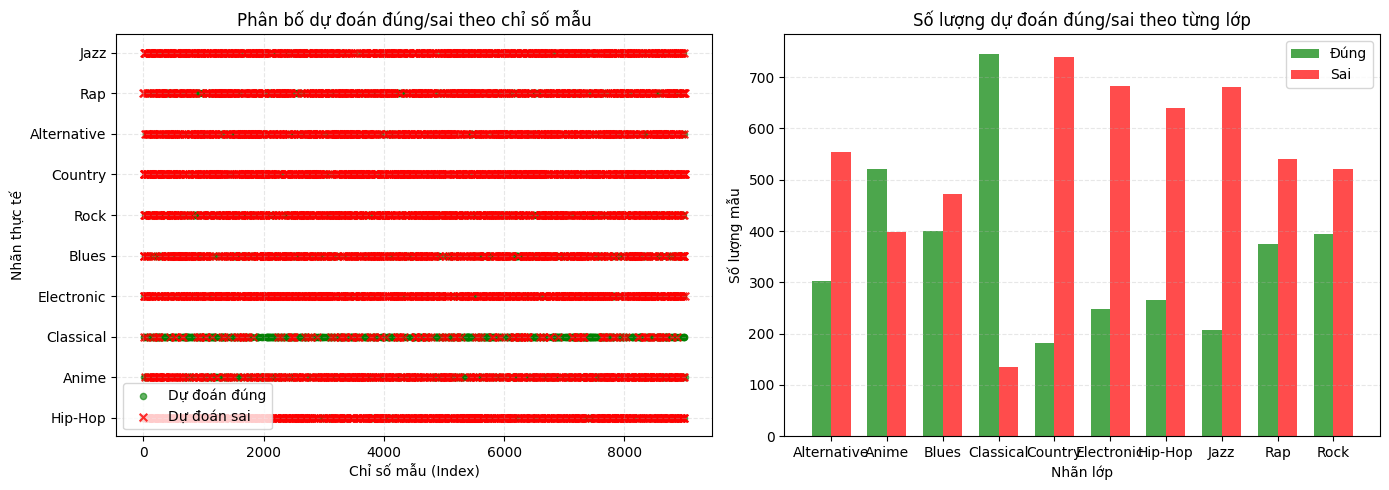

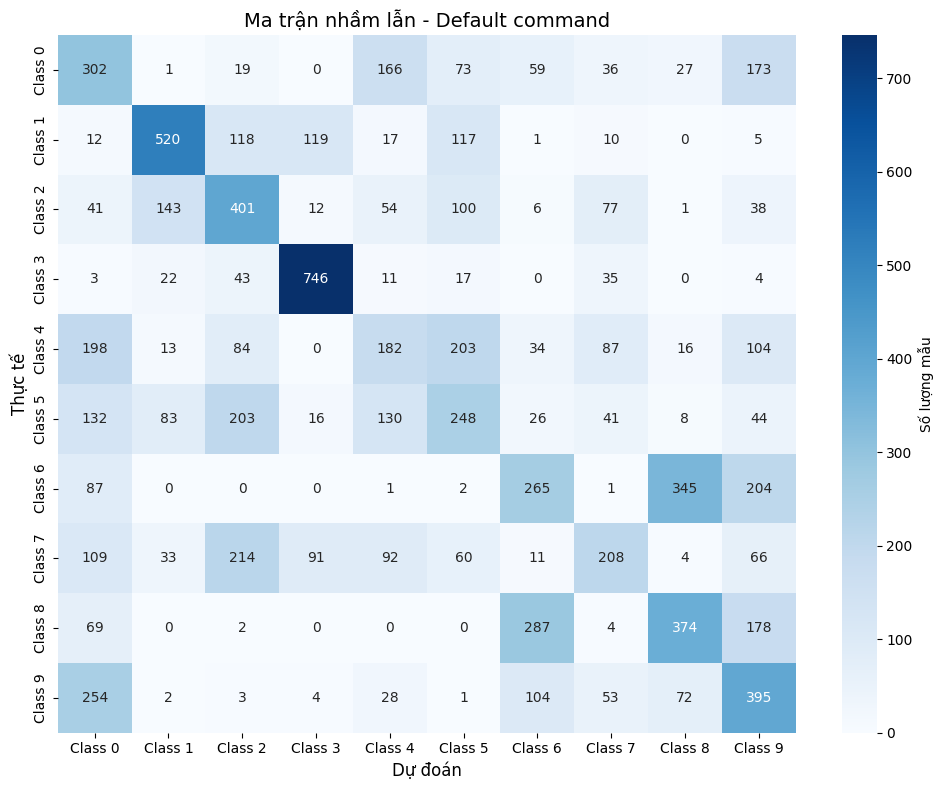

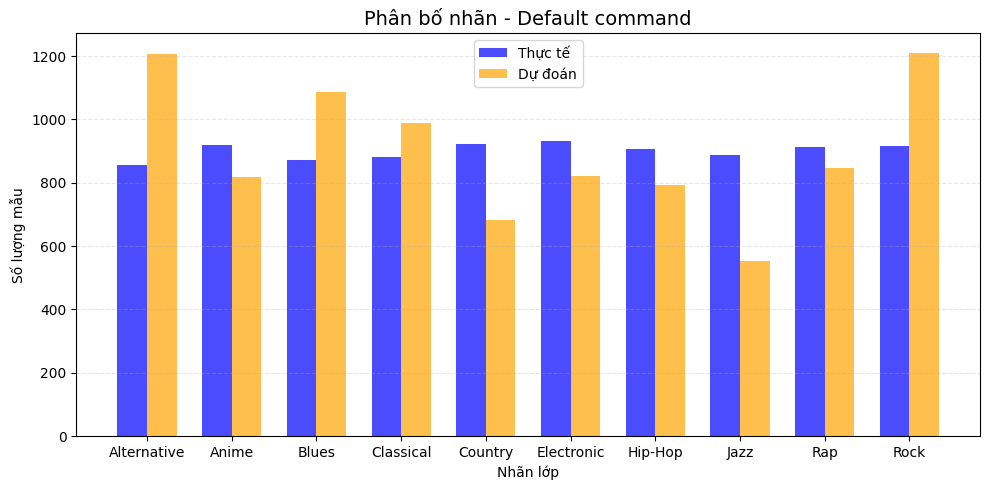

In [59]:
model = MyNavieBayes()
helper_and_plot(*split_train_test(X, y, test_size=0.2, classified_idx=0), model=model, reduce_name="LDA",n_components=2)

Nhận xét Phương pháp giảm chiều LDA
1. Hiệu suất tổng quan

Độ chính xác (Accuracy Test) = 0.4044
→ Chỉ khoảng 40% mẫu test được dự đoán đúng.

Độ chính xác (Train) = 0.4072, gần bằng Test
→ Mô hình không bị overfitting, nhưng hiệu suất còn thấp ⇒ có thể do dữ liệu khó phân biệt hoặc đặc trưng chưa đủ mạnh (underfitting).

2. Biểu đồ phân bố nhãn

Các thanh màu vàng (dự đoán) lệch khá nhiều so với thanh xanh (thực tế) ở vài lớp:

Alternative, Rock → Dự đoán nhiều hơn thực tế ⇒ mô hình hay đoán nhầm sang các lớp này.

Country, Jazz → Dự đoán ít hơn thực tế ⇒ mô hình khó nhận dạng các lớp này.

3. Nguyên nhân

Đặc trưng (feature) giữa các thể loại nhạc khá giống nhau, gây khó phân biệt.

Khi dùng LDA giảm xuống 2 chiều, có thể làm mất nhiều thông tin ⇒ hiệu suất giảm.

Phân phối không chuẩn khiến mô hình Naviebayes giả định sai mô hình ⇒
Ước lượng xác suất kém chính xác
